# Bayesian optimization,bandits and Thompson sampling

Notebook putting the excellent Machine lectures of Nando de Freitas in code/(LA)tex(t). We are dealing with Bayesian optimization,bandits and Thompson sampling in particular. Slides on http://www.cs.ubc.ca/~nando/540-2013/lectures/l7.pdf

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import Image
from bayes_opt import BayesianOptimization # pip install bayesian-optimization

# path to png's
PATH = 'C:\\Users\\Egbert\\datascience\\ubc_ml\\tut_png\\bayesian_learning\\'

Multi-armed bandit problem: you want to try the bandit that most likely gives you money. Assume there is a true reward for the bandits and we have a true cost function (that only the Casino knows so all we can do is to sample a few machines and try to infer ourselves what the cost function is). Based on 2 observations we can fit a Gaussian through those 2 data points.

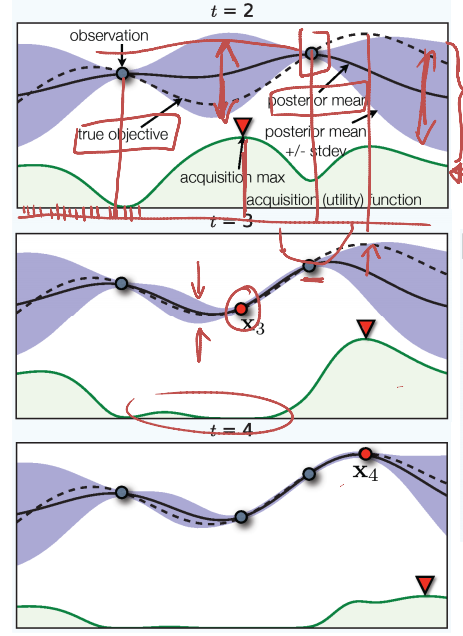

In [2]:
Image(PATH + 'bandits.png', width = 600)

We assume the function is smooth and we would fit a Gaussian. The mission is to find where the peak of the function is occuring (upper pic the straight red line departing from the dotted true function line). Another mechanism we need is to have a way to decide which points to take next (The green 'acquisition-function' line can give us a good indication because it decides how the data can be 'acquired', thereby trading off **'exploration'** vs **'exploitation'**. Since the second blue points has a higher reward as compared to point A, we should look near point B. In order to decide which points to explore, we use the confidence bands. 

If we choose a point a point where the confidence intervals are the widest (much uncertainty), this is where we gain most information. We just basically need to know the maximum of the confidence interval values. Drawing a new point at x=3, I refit my Gaussian process. In the second picture, if we'd repeat the process, we'd draw at the red triangle position. High-over, this is **Bayesian optimization** :

**Exploration-Exploitation trade-off - (EE)** is a fundamental dilemma between choosing what you know and getting something close to what you expect ('exploitation') and choosing something you are not sure about and possibly learn more ('exploration'). Optimal learning requires that you sometimes make bad choices.

Recall the expression for the GP predictions:

If you want to make a prediction and we have data $D_{1:t}$, and a new test point $x_{t+1}$, our prediction is Gaussian and has 2 stats: mean and variance. 

$\underset{prediction}{P(Y_{t}+ 1} \rvert \mathcal{D}_{1:t}, \underset{test}{X_{t+1}} = \mathcal{N}(\mu_{t}(X_{t+1}), \sigma_{t}^{2}(X_{t+1})+ \sigma_{noise}^{2})$

$\mu_{t}(X_{t+1}) = k^{T}[K + \sigma_{noise}^{2}I]^{-1}Y_{1:t}$

$\sigma^{2}_{t}(X_{t+1}) = k(x_{t+1},k(x_{t+1}) - k^{T}[K + \sigma_{noise}^{2}I]^{-1}k$

We should choose the next point x where the mean is high (exploitation) and the variance is high (exploration). We can balance this EE trade-off with the acquisition function:

$\mu(x) + \mathcal{K}\sigma(x)$

If you think that high variance is more important (we're in exploration modus), you would choose a trade-off parameter (kappa K) to be very large, if we'd think the mean is more important, we'd choose a small value for K.

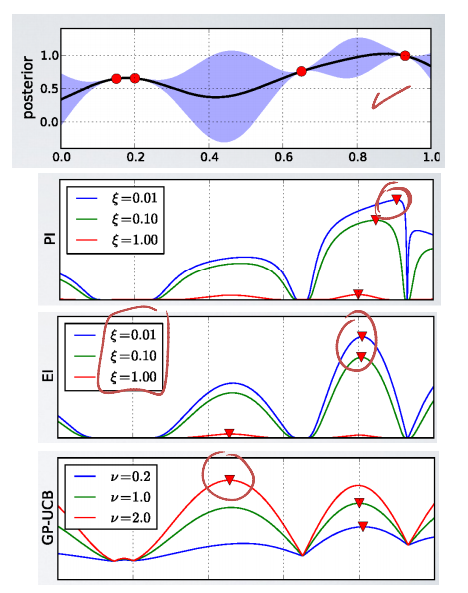

In [3]:
Image(PATH + 'acquisition_functions.png', width =600)

### Acquisition functions

- 1) PI =  **Probability of Improvement** 

$PI(x) = P(f(x) \geqslant \mu^{+} + \epsilon)$ 

$\Phi(\frac{\mu(x) - \mu^{+} - \epsilon}{\sigma(x)})$

where $\mu_{+}$ is the best observed value and $f^{max} = \mu^{+} + \epsilon$, $\Phi$ is the cumulative for the AUC.

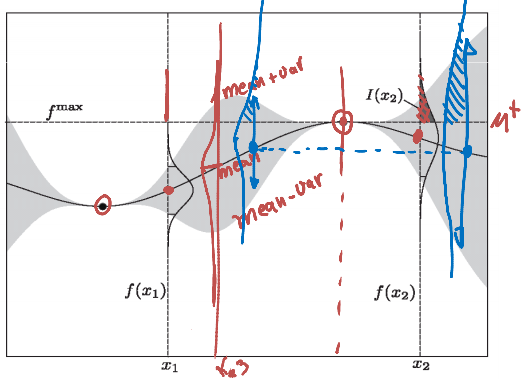

In [4]:
Image(PATH + 'probability_of_improvement.png', width=600)

Assuming samplings at the red-encircled points P1, P2, a GP is fitted. The black line is the $\mu$ of GP and grey confidence bounds represent the GP variance. Using PI, the criteria that we'll use for EE will be to look at the AUC of the Gaussian that has width implied by sigma and that is located at the mean. Off course X2 has a much higher AUC compared to X1. 

- 2) EP =  **Expected Improvement** 

First define the term **Expected utility criterion** : at iteration n+1, choose the point that minimizes the distance to the objective evaluated at the maximum $x_{*}$. Let's assume we know the true function and that $x_{*}$ is the location of the maximum.

$X_{n+1} = \underset{x}{argmin} \hspace{1mm}\mathbb{E}(\underset{GP}{\rVert\mathcal{f}_{n+1}(x)} - \underset{true function}{\mathcal{f}(x^{*})}\rVert \hspace{1mm} \rvert \mathcal{D}_{n})$ 

Our mission is to find the X (regardless of what the GP function is) that would minimize the difference between the function and the actual true function. By integrating over f, we say, regardless of what f is, we want to be as close to $x_{*}$ as possible. The catch is we don't know the true function and to overcome this, Mockus, proposed the following function: 

$x = \underset{x}{argmax} \hspace{1mm} \mathbb{E}(max \{ 0, \mathcal{f}_{n+1}(x) - \mathcal{f}^{max} \} \rvert \mathcal{D}_{n})$

For this expected improvement, we can obtain an analytical expression:

$EI_{x} = \begin{cases}
(\mu(x) - \mu^{'} - \epsilon) \Phi (\mathcal{Z}) + \sigma(x)\phi(\mathcal{Z}),  & if \sigma(x) > 0 \\
0, & if \sigma(x) = 0
\end{cases}$

where $\phi(.)$ denotes the PDF of the Standard Normal
and where $\Phi$ denotes the the CDF of the Standard Normal

- 3) **GP- UCB (Upper Confidence Bounds)**

Here we define a notion of regret and cumulative regret as follows:

$r(x) = f(x^{*}) - f(x)$

$\mathcal{R}_{t} = r(X_{1}) + .. + r(X_{T})$

the GP=-UCB criterion is as follows:

$GP-UCB(x) = \mu(X) + \sqrt{v \beta_{t} \sigma(x)}$

where Beta is set using a simple concentration bound.

Let's see some code with the **'Bayesian optimization'** module: a pure Python implementation of bayesian global optimization with gaussian processes. https://github.com/fmfn/BayesianOptimization

### Target Function

Lets create a target 1-D function with multiple local maxima to test and visualize how the BayesianOptimization package works. The target function we will try to maximize is the following:
$$f(x) = e^{-(x - 2)^2} + e^{-\frac{(x - 6)^2}{10}} + \frac{1}{x^2 + 1}, $$
its maximum is at $x = 2$ and we will restrict the interval of interest to $x \in (-2, 10)$.
Notice that, in practice, this function is unknown, the only information we have is obtained by sequentially probing it at different points. Bayesian Optimization works by contructing a posterior distribution of functions that best fit the data observed and chosing the next probing point by balancing exploration and exploitation.

In [11]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

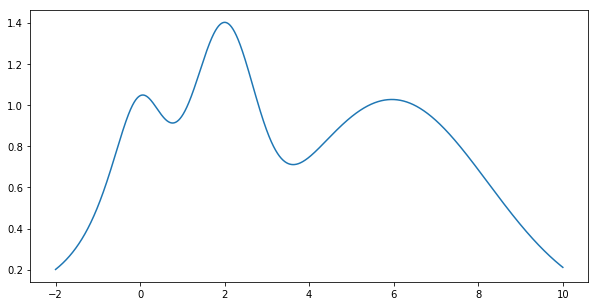

In [12]:
x = np.linspace(-2, 10, 10000).reshape(-1,1)
y = target(x)
fig, ax =plt.subplots(figsize= [10,5])
ax.plot(x,y);

In [7]:
# create the bayes_opt object and pass the function to be maximized
# together with the parameters names and their bounds.
bo = BayesianOptimization(target, {'x': (-2, 10)})

In [10]:
bo.maximize(init_points=2, n_iter=0, acq='ucb', kappa=5)

ValueError: zero-size array to reduction operation maximum which has no identity

In this example we will use the **Upper Confidence Bound (UCB) as our utility function**. It has the free parameter $\kappa$ controlling the EE trade-off. We will set $\kappa=5$ which, in this case, makes the algorithm quite bold. Additionally we will use the cubic correlation in our Gaussian Process.

### Plotting and visualizing the algorithm at each step

In [13]:
from matplotlib import gridspec

def posterior(bo, x, xmin=-2, xmax=10):
    xmin, xmax = -2, 10
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma = bo.gp.predict(x, return_std=True)
    return mu, sigma

def plot_gp(bo, x, y):
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(bo, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(bo.X.flatten(), bo.Y, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility = bo.util.utility(x, bo.gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

C:\Users\Egbert\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required.

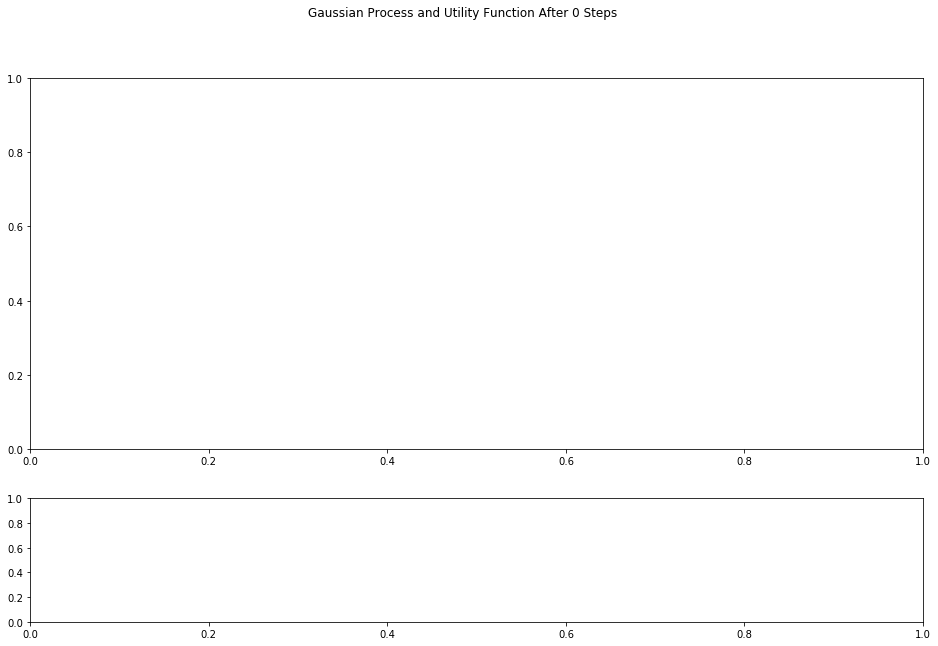

In [15]:
plot_gp(bo, x, y)

In [16]:
# run this again in a new cell to explore more steps
bo.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(bo, x, y)

ValueError: zero-size array to reduction operation maximum which has no identity